# Setup

In [1]:
%load_ext autoreload
%autoreload 2
from dictionary_learning import CrossCoder
from torch.nn.functional import cosine_similarity
import torch as th
import numpy as np
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
from tqdm.notebook import tqdm
import warnings

th.set_grad_enabled(False)
exp_name = "eval_crosscoder"
import sys

sys.path.append("..")

In [2]:
crosscoder = "connor"
extra_args = []
exp_id = ""
device = "cuda"

In [3]:
from argparse import ArgumentParser
from shutil import rmtree
from tools.utils import load_dictionary_model, model_path_to_name

parser = ArgumentParser()
parser.add_argument("--base-layer", type=int, default=0)
parser.add_argument("--instruct-layer", type=int, default=1)
parser.add_argument("--add-activation-stats", action="store_true")
parser.add_argument("--upload", action="store_true")
parser.add_argument("--overwrite", action="store_true")
args = parser.parse_args(extra_args)
print(args)
base_layer = args.base_layer
instruct_layer = args.instruct_layer
UPLOAD = args.upload
OVERWRITE = args.overwrite

if OVERWRITE:
    print("Overwriting existing results")


if not Path(crosscoder).exists():
    crosscoder_name = "_".join(crosscoder.split("/")[-2:])
else:
    crosscoder_name = model_path_to_name(Path(crosscoder))

coder = load_dictionary_model(crosscoder)
num_layers, activation_dim, dict_size = coder.encoder.weight.shape

save_path = (
    Path("./results") / exp_name / (crosscoder_name + (f"_{exp_id}" if exp_id else ""))
)
save_path_extra = save_path / "extra"
save_path_extra.mkdir(exist_ok=True, parents=True)
save_path_html = save_path / "html"
save_path_html.mkdir(exist_ok=OVERWRITE)
save_path_data = save_path / "data"
save_path_data.mkdir(exist_ok=OVERWRITE)
if device == "auto":
    device = th.device("cuda" if th.cuda.is_available() else "cpu")
else:
    device = th.device(device)
all_info = {}
feature_df = {k: {} for k in range(dict_size)}

Namespace(base_layer=0, instruct_layer=1, add_activation_stats=False)


/root/repos/representation-structure-comparison/notebooks/../utils.py:428: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = th.load(weights_path, map_location=cfg[

CrossCoder(
  (encoder): CrossCoderEncoder()
  (decoder): CrossCoderDecoder()
)


/tmp/ipykernel_6326/3485541657.py:25: UserWarning: Folder results/eval_crosscoder/connor_new already exists, and was removed
  warnings.warn(f"Folder {save_path} already exists, and was removed")


# Latent analysis on test set

In [4]:
if args.add_activation_stats:
    stats_path = Path(f"../stats/{crosscoder_name}")
    fw_stats = th.load(stats_path / "fineweb.pt").rescaled.joint
    lmsys_stats = th.load(stats_path / "lmsys.pt").rescaled.joint
    fw_deads = (fw_stats.non_zero_counts == 0).cpu()
    fw_avg_activations = (
        fw_stats.avg_activation
        * fw_stats.total_tokens
        / fw_stats.non_zero_counts.float()
    ).cpu()
    fw_freqs = (fw_stats.non_zero_counts.float() / fw_stats.total_tokens).cpu()
    lmsys_deads = (lmsys_stats.non_zero_counts == 0).cpu()
    lmsys_avg_activations = (
        (
            lmsys_stats.avg_activation
            * lmsys_stats.total_tokens
            / lmsys_stats.non_zero_counts.float()
        ).cpu()
    ).cpu()
    lmsys_freqs = (lmsys_stats.non_zero_counts.float() / lmsys_stats.total_tokens).cpu()
    freqs = (
        (fw_stats.non_zero_counts + lmsys_stats.non_zero_counts).float()
        / (fw_stats.total_tokens + lmsys_stats.total_tokens).float()
    ).cpu()
    deads = fw_deads & lmsys_deads
    avg_activations = (
        fw_avg_activations * fw_stats.non_zero_counts.cpu()
        + lmsys_avg_activations * lmsys_stats.non_zero_counts.cpu()
    ).float() / (fw_stats.non_zero_counts + lmsys_stats.non_zero_counts).float().cpu()

    for f_idx, (
        fw_dead,
        fw_freq,
        lmsys_dead,
        lmsys_freq,
        freq,
        dead,
        avg_activation,
        lmsys_avg_activation,
        fw_avg_activation,
    ) in enumerate(
        zip(
            fw_deads,
            fw_freqs,
            lmsys_deads,
            lmsys_freqs,
            freqs,
            deads,
            avg_activations,
            lmsys_avg_activations,
            fw_avg_activations,
        )
    ):
        feature_df[f_idx]["fw_dead"] = fw_dead.item()
        feature_df[f_idx]["fw_freq"] = fw_freq.item()
        feature_df[f_idx]["lmsys_dead"] = lmsys_dead.item()
        feature_df[f_idx]["lmsys_freq"] = lmsys_freq.item()
        feature_df[f_idx]["freq"] = freq.item()
        feature_df[f_idx]["dead"] = dead.item()
        feature_df[f_idx]["avg_activation"] = avg_activation.item()
        feature_df[f_idx]["lmsys_avg_activation"] = lmsys_avg_activation.item()
        feature_df[f_idx]["fw_avg_activation"] = fw_avg_activation.item()

    print(f"frac of dead features: {deads.float().mean().item()}")
    th.save(deads, save_path_data / "deads.pt")
else:
    deads = th.zeros(dict_size, dtype=bool)
alive_mask = ~deads

# Weight analysis

## Compare feature norms

In [11]:
norms = coder.decoder.weight.norm(dim=-1)
norm_diffs = (
    (norms[base_layer] - norms[instruct_layer]) / norms.max(dim=0).values + 1
) / 2
norm_diffs = norm_diffs.cpu()
for f_idx, (base_norm, instruct_norm, norm_diff) in enumerate(
    zip(norms[base_layer], norms[instruct_layer], norm_diffs)
):
    feature_df[f_idx]["dec_base_norm"] = base_norm.item()
    feature_df[f_idx]["dec_instruct_norm"] = instruct_norm.item()
    feature_df[f_idx]["dec_norm_diff"] = norm_diff.item()

# Create color array based on norm difference categories
colors = [
    (
        "green"
        if x <= 0.1
        else "orange" if x >= 0.9 else "blue" if 0.4 <= x <= 0.6 else "grey"
    )
    for x in norm_diffs[alive_mask]
]

# Create masks for each category
it_only_mask = norm_diffs[alive_mask] <= 0.1
base_only_mask = norm_diffs[alive_mask] >= 0.9
shared_mask = (0.4 <= norm_diffs[alive_mask]) & (norm_diffs[alive_mask] <= 0.6)
other_mask = ~(it_only_mask | base_only_mask | shared_mask)

# Create figure
fig = go.Figure()

# Add histogram traces for each category
fig.add_trace(
    go.Histogram(
        x=norm_diffs[alive_mask][it_only_mask],
        name="Chat only",
        marker_color="green",
        nbinsx=50,
    )
)

fig.add_trace(
    go.Histogram(
        x=norm_diffs[alive_mask][base_only_mask],
        name="Base only",
        marker_color="orange",
        nbinsx=50,
    )
)

fig.add_trace(
    go.Histogram(
        x=norm_diffs[alive_mask][shared_mask],
        name="Shared",
        marker_color="blue",
        nbinsx=50,
    )
)

fig.add_trace(
    go.Histogram(
        x=norm_diffs[alive_mask][other_mask],
        name="Other",
        marker_color="grey",
        nbinsx=50,
    )
)

fig.update_layout(
    annotations=[
        dict(
            x=0,
            y=0,
            xref="x",
            yref="paper",
            text="  <b>(Chat only)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
            font=dict(color="green"),
        ),
        dict(
            x=0.5,
            y=0,
            xref="x",
            yref="paper",
            text="    <b>(shared)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
            font=dict(color="blue"),
        ),
        dict(
            x=1,
            y=0,
            xref="x",
            yref="paper",
            text="  <b>(Base only)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
            font=dict(color="orange"),
        ),
    ],
    shapes=[
        dict(
            type="line",
            x0=0.1,
            y0=0,
            x1=0.1,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="green", width=2),
        ),
        dict(
            type="line",
            x0=0.9,
            y0=0,
            x1=0.9,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="orange", width=2),
        ),
        dict(
            type="line",
            x0=0.4,
            y0=0,
            x1=0.4,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="blue", width=2),
        ),
        dict(
            type="line",
            x0=0.6,
            y0=0,
            x1=0.6,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="blue", width=2),
        ),
    ],
    showlegend=False,
)
fig.update_xaxes(tickvals=[0, 0.5, 1])
# fig.update_traces(hovertemplate='Feature Index: %{text}<br>Value: %{y}', text=sorted_norm_diffs.indices)
fig.update_xaxes(title="Sorted Features (Highest to Lowest Difference)")
fig.update_yaxes(title="Relative Norm Difference")
fig.update_layout(barmode="stack")
fig.show()
fig.write_html(save_path_html / "decoder_norm_diffs.html")
fig.write_image(save_path / "decoder_norm_diffs.png")

In [12]:
fig = px.histogram(
    x=norm_diffs[deads],
    title="Relative difference in decoder dead feature norms",
    orientation="v",
    nbins=50,
)
fig.update_layout(
    annotations=[
        dict(
            x=0,
            y=0,
            xref="x",
            yref="paper",
            text="  <b>(Chat only)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
        ),
        dict(
            x=0.5,
            y=0,
            xref="x",
            yref="paper",
            text="    <b>(shared)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
        ),
        dict(
            x=1,
            y=0,
            xref="x",
            yref="paper",
            text="  <b>(Base only)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
        ),
    ]
)
fig.update_xaxes(tickvals=[0, 0.5, 1])
# fig.update_traces(hovertemplate='Feature Index: %{text}<br>Value: %{y}', text=sorted_norm_diffs.indices)
fig.update_xaxes(title="Sorted Features (Highest to Lowest Difference)")
fig.update_yaxes(title="Relative Norm Difference")
fig.show()
fig.write_html(save_path_html / "decoder_norm_diffs_dead.html")
fig.write_image(save_path_extra / "decoder_norm_diffs_dead.png")

In [ ]:
# save Chat only and base only feature index
treshold = 0.1
only_it_feature_indices = th.nonzero(norm_diffs < treshold, as_tuple=True)[0]
only_base_feature_indices = th.nonzero(norm_diffs > 1 - treshold, as_tuple=True)[0]
shared_feature_indices = th.nonzero((norm_diffs - 0.5).abs() < treshold, as_tuple=True)[
    0
]

th.save(only_it_feature_indices, save_path_data / "only_it_decoder_feature_indices.pt")
th.save(
    only_base_feature_indices, save_path_data / "only_base_decoder_feature_indices.pt"
)
th.save(shared_feature_indices, save_path_data / "shared_decoder_feature_indices.pt")
all_info["frac of dead Chat only features"] = (
    deads[only_it_feature_indices].float().mean().item()
)
all_info["frac of dead base only features"] = (
    deads[only_base_feature_indices].float().mean().item()
)
all_info["frac of dead shared features"] = (
    deads[shared_feature_indices].float().mean().item()
)
is_other_feature = th.ones_like(deads, dtype=bool)
is_other_feature[only_it_feature_indices] = False
is_other_feature[only_base_feature_indices] = False
is_other_feature[shared_feature_indices] = False
all_info["frac of dead other features"] = deads[is_other_feature].float().mean().item()

for f_idx in only_it_feature_indices.tolist():
    feature_df[f_idx]["tag"] = "Chat only"
for f_idx in only_base_feature_indices.tolist():
    feature_df[f_idx]["tag"] = "Base only"
for f_idx in shared_feature_indices.tolist():
    feature_df[f_idx]["tag"] = "Shared"
for f_idx in is_other_feature.nonzero(as_tuple=True)[0].tolist():
    feature_df[f_idx]["tag"] = "Other"

In [15]:
enc_norms = coder.encoder.weight.norm(dim=1)
enc_norm_diffs = (
    (enc_norms[base_layer] - enc_norms[instruct_layer]) / enc_norms.max(dim=0).values
    + 1
) / 2
enc_norm_diffs = enc_norm_diffs.cpu()

for f_idx, (base_norm, instruct_norm, norm_diff) in enumerate(
    zip(enc_norms[base_layer], enc_norms[instruct_layer], enc_norm_diffs)
):
    feature_df[f_idx]["enc_base_norm"] = base_norm.item()
    feature_df[f_idx]["enc_instruct_norm"] = instruct_norm.item()
    feature_df[f_idx]["enc_norm_diff"] = norm_diff.item()

fig = px.histogram(
    x=enc_norm_diffs[alive_mask],
    title="Relative difference in encoder alive feature norms",
    orientation="v",
    nbins=50,
)
fig.update_xaxes(title="Relative Norm Difference")
fig.update_yaxes(title="Count")
fig.update_layout(
    annotations=[
        dict(
            x=0,
            y=0,
            xref="x",
            yref="paper",
            text="<b>(Chat only)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
        ),
        dict(
            x=0.5,
            y=0,
            xref="x",
            yref="paper",
            text="<b>(shared)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
        ),
        dict(
            x=1,
            y=0,
            xref="x",
            yref="paper",
            text="<b>(Base only)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
        ),
    ]
)
fig.show()
fig.write_html(save_path_html / "encoder_norm_diffs.html")
fig.write_image(save_path / "encoder_norm_diffs.png")

In [ ]:
enc_norms = coder.encoder.weight.norm(dim=1)
enc_norm_diffs = (
    (enc_norms[base_layer] - enc_norms[instruct_layer]) / enc_norms.max(dim=0).values
    + 1
) / 2

for f_idx, (base_norm, instruct_norm, norm_diff) in enumerate(
    zip(enc_norms[base_layer], enc_norms[instruct_layer], enc_norm_diffs)
):
    feature_df[f_idx]["enc_base_norm"] = base_norm.item()
    feature_df[f_idx]["enc_instruct_norm"] = instruct_norm.item()
    feature_df[f_idx]["enc_norm_diff"] = norm_diff.item()

fig = px.histogram(
    x=enc_norm_diffs[deads],
    title="Relative difference in encoder dead feature norms",
    orientation="v",
    nbins=50,
)
fig.update_xaxes(title="Relative Norm Difference")
fig.update_yaxes(title="Count")
fig.update_layout(
    annotations=[
        dict(
            x=0,
            y=0,
            xref="x",
            yref="paper",
            text="<b>(Chat only)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
        ),
        dict(
            x=0.5,
            y=0,
            xref="x",
            yref="paper",
            text="<b>(shared)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
        ),
        dict(
            x=1,
            y=0,
            xref="x",
            yref="paper",
            text="<b>(Base only)</b>",
            showarrow=False,
            yanchor="top",
            xanchor="left",
        ),
    ]
)
fig.show()
fig.write_html(save_path_html / "encoder_norm_diffs_dead.html")
fig.write_image(save_path_extra / "encoder_norm_diffs_dead.png")

## Cosine similarity

### Decoder

In [18]:
decoder_cos_sims = cosine_similarity(
    coder.decoder.weight[base_layer], coder.decoder.weight[instruct_layer], dim=1
)
for f_idx, cos_sim in enumerate(decoder_cos_sims):
    feature_df[f_idx]["dec_cos_sim"] = cos_sim.item()

decoder_cos_sims_sorted = decoder_cos_sims.sort(descending=True)

# Calculate mean cosine similarity between random latent vectors
num_samples = 10000
random_idx = th.randint(0, coder.decoder.weight.shape[1], (num_samples, 2))
random_cos_sims = cosine_similarity(
    coder.decoder.weight[base_layer][random_idx[:, 0]],
    coder.decoder.weight[instruct_layer][random_idx[:, 1]],
    dim=1,
)
mean_random_cos_sim = random_cos_sims.mean().item()

In [20]:
fig = px.histogram(
    x=decoder_cos_sims[alive_mask].cpu(),
    title="Cosine similarity between decoder alive feature vectors",
    orientation="v",
    nbins=50,
)
fig.update_xaxes(title="Cosine Similarity")
fig.update_yaxes(title="Count")
fig.add_vline(
    x=mean_random_cos_sim,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Mean Random Cosine Similarity: {mean_random_cos_sim:.4f}",
)
fig.show()
fig.write_html(save_path_html / "decoder_cos_sims.html")
fig.write_image(save_path / "decoder_cos_sims.png")

In [54]:
import pandas as pd

df = pd.DataFrame(feature_df).T

filtered_decoder_cos_sims = decoder_cos_sims[alive_mask].cpu()
filtered_tags = df["tag"][alive_mask.cpu().numpy()]

# Normalize by amount of each tag that are not dead
tag_counts = filtered_tags.value_counts()

# Create histogram with normalized counts
fig = px.histogram(
    x=filtered_decoder_cos_sims,
    title="Cosine similarity between decoder feature vectors (Alive)",
    orientation="v",
    nbins=50,
    color=filtered_tags,
    color_discrete_map={
        "Shared": "blue",
        "Base only": "orange",
        "Chat only": "green",
        "Other": "grey",
    },
    # Normalize histogram counts by tag frequency
    histnorm="probability",
    # Group by tag to normalize each category separately
    barmode="group",
)

fig.update_xaxes(title="Cosine Similarity")
fig.update_yaxes(title="Normalized Count", range=[0, 1])
fig.add_vline(
    x=mean_random_cos_sim,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Mean Random Cosine Similarity: {mean_random_cos_sim:.4f}",
)
fig.show()
fig.write_html(save_path_html / "decoder_cos_sims_colored.html")
fig.write_image(save_path / "decoder_cos_sims_colored.png")

In [28]:
fig = px.histogram(
    x=decoder_cos_sims[deads],
    title="Cosine similarity between decoder dead feature vectors",
    orientation="v",
    nbins=50,
)
fig.update_xaxes(title="Cosine Similarity")
fig.update_yaxes(title="Count")
fig.add_vline(
    x=mean_random_cos_sim,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Mean Random Cosine Similarity: {mean_random_cos_sim:.4f}",
)
fig.show()
fig.write_html(save_path_html / "decoder_cos_sims_dead.html")
fig.write_image(save_path_extra / "decoder_cos_sims_dead.png")

### Encoder

In [42]:
encoder_cos_sims = cosine_similarity(
    coder.encoder.weight[base_layer], coder.encoder.weight[instruct_layer], dim=0
)
for f_idx, cos_sim in enumerate(encoder_cos_sims):
    feature_df[f_idx]["enc_cos_sim"] = cos_sim.item()

mean_random_cos_sim_encoder = (
    cosine_similarity(
        coder.encoder.weight[base_layer][:, random_idx[:, 0]],
        coder.encoder.weight[instruct_layer][:, random_idx[:, 1]],
        dim=0,
    )
    .mean()
    .item()
)

In [43]:
fig = px.histogram(
    x=encoder_cos_sims[alive_mask].cpu(),
    title="Cosine similarity between encoder alive feature vectors",
    orientation="v",
    nbins=50,
)
fig.update_xaxes(title="Cosine Similarity")
fig.update_yaxes(title="Count")
fig.add_vline(
    x=mean_random_cos_sim_encoder,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Mean Random Cosine Similarity: {mean_random_cos_sim_encoder:.4f}",
)
fig.show()
fig.write_html(save_path_html / "encoder_cos_sims.html")
fig.write_image(save_path / "encoder_cos_sims.png")

In [44]:
fig = px.histogram(
    x=encoder_cos_sims[deads],
    title="Cosine similarity between encoder dead feature vectors",
    orientation="v",
    nbins=50,
)
fig.update_xaxes(title="Cosine Similarity")
fig.update_yaxes(title="Count")
fig.add_vline(
    x=mean_random_cos_sim_encoder,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Mean Random Cosine Similarity: {mean_random_cos_sim_encoder:.4f}",
)
fig.show()
fig.write_html(save_path_html / "encoder_cos_sims_dead.html")
fig.write_image(save_path_extra / "encoder_cos_sims_dead.png")

# End

In [45]:
import pandas as pd
import json

pd.DataFrame(feature_df).T.to_csv(save_path_data / "feature_df.csv")
with open(save_path_data / "all_info.json", "w") as f:
    json.dump(all_info, f)

In [50]:
df = pd.DataFrame(feature_df).T
if args.add_activation_stats:
    display(df.sort_values(by="freq", ascending=False))
else:
    display(df.sort_values(by="dec_norm_diff", ascending=True))

dec_base_norm dec_instruct_norm dec_norm_diff        tag enc_base_norm  \
13912      0.000004           1.51778      0.000001    IT only      0.023624   
3138       0.000005          1.218269      0.000002    IT only      0.021855   
12101      0.000005          1.119969      0.000002    IT only      0.026915   
5646       0.000005          1.039828      0.000002    IT only      0.017693   
2250       0.000005          0.978847      0.000002    IT only      0.077392   
...             ...               ...           ...        ...           ...   
3264       1.059749          0.000003      0.999999  Base only      0.006281   
15033      1.247987          0.000003      0.999999  Base only      0.008086   
346        1.214332          0.000003      0.999999  Base only      0.050785   
1878       1.143137          0.000002      0.999999  Base only      0.009076   
1063        1.06895          0.000002      0.999999  Base only      0.037798   

      enc_instruct_norm enc_norm_diff dec_cos_sim enc_cos_sim  
13912          0.022711      0.501352    0.326916   -0.636562  
3138           0.093322       0.34292    0.706691   -0.576625  
12101          0.009657      0.542796    0.662246   -0.531692  
5646           0.015524      0.506537    0.665547   -0.565394  
2250           0.056126      0.583318    0.575113   -0.570161  
...                 ...           ...         ...         ...  
3264           0.108373       0.21236    0.516876   -0.575389  
15033          0.020414      0.472119    0.468202    -0.55712  
346            0.044009      0.514093    0.508731    -0.54602  
1878           0.058979      0.347174    0.560581   -0.563314  
1063           0.029703      0.523282    0.494413   -0.599737  

[16384 rows x 9 columns]

# Additional Analysis

In [1]:
import sys

sys.path.append("..")
import plotly.express as px

In [16]:
from tools.cc_utils import load_latent_df

df = load_latent_df()

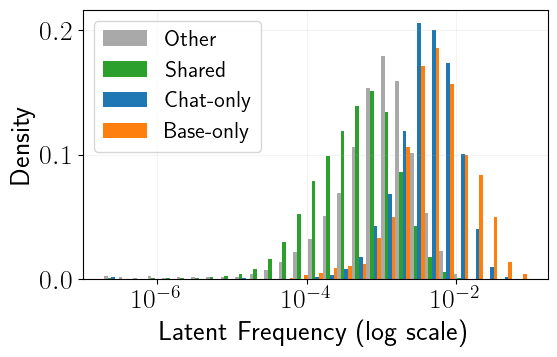

In [21]:
if "lmsys_freq" in df.columns:
    import numpy as np
    import matplotlib.pyplot as plt

    # Get unique tags for grouping
    tags = df["tag"].unique()

    # Create figure
    fig = plt.figure(figsize=(6, 3.5))
    ax = fig.add_subplot(111)

    # Colors matching the other plot
    colors = {'Chat only': 'C0', 'IT only': 'C0', 'Base only': 'C1', 'Shared': 'C2', 'Other': 'darkgray'}

    # Apply log transformation to frequency data
    all_freqs = np.concatenate([np.log10(df[(df['tag'] == tag) & (df['lmsys_freq'] > 1e-8)]['lmsys_freq'] + 1e-10) for tag in tags])
    
    # Determine bin edges in log space
    bins = np.linspace(min(all_freqs), max(all_freqs), 30)
    bin_width = bins[1] - bins[0]

    # Calculate bar width and offsets
    n_tags = len(tags)
    single_bar_width = bin_width / (n_tags)  # Add 1 for spacing
    offsets = np.linspace(-bin_width/2 + single_bar_width/2, 
                        bin_width/2 - single_bar_width/2, 
                        n_tags)

    # Plot histogram for each tag
    for tag, offset in zip(tags, offsets):
        tag_data = df[df['tag'] == tag]
        # Apply log transformation to the data
        log_freqs = np.log10(tag_data['lmsys_freq'] + 1e-10)  # Add small constant to avoid log(0)
        counts, _ = np.histogram(log_freqs, bins=bins)
        normalized_counts = counts / counts.sum()
        bin_centers = (bins[:-1] + bins[1:]) / 2

        ax.bar(
            bin_centers + offset,
            normalized_counts,
            width=single_bar_width,
            alpha=1.0,
            label=tag.replace("IT only", "Chat-only").replace("Base only", "Base-only"),
            color=colors[tag],
        )

    # Styling
    plt.rcParams["text.usetex"] = True
    plt.rcParams.update({"font.size": 20})

    ax.grid(True, alpha=0.15)
    
    # Use more human-readable tick values at nice round numbers
    log_ticks = np.array([-10, -8, -6, -4, -2])  # Powers of 10 for cleaner values
    log_ticks = log_ticks[np.logical_and(log_ticks >= min(all_freqs), log_ticks <= max(all_freqs))]
    if len(log_ticks) < 3:  # Ensure we have enough ticks
        log_ticks = np.linspace(min(all_freqs), max(all_freqs), 5)
        log_ticks = np.round(log_ticks)  # Round to integers for cleaner display
    
    ax.set_xticks(log_ticks)
    ax.set_xticklabels([f"$10^{{{int(x)}}}$" for x in log_ticks])  # Use LaTeX for cleaner display
    
    ax.set_xlabel("Latent Frequency (log scale)")
    ax.set_ylabel("Density")

    # Move legend below plot
    ax.legend(fontsize=16, loc='upper left')
    
    plt.savefig("latent_frequency_histogram.pdf", bbox_inches='tight')
    plt.show()

# Upload

In [ ]:
if UPLOAD:
    from tools.cc_utils import push_dictionary_model, push_latent_df

    if Path(crosscoder).exists():
        print(f"Pushing local model {crosscoder} to the hub")
        model_repo_id = push_dictionary_model(model_path=Path(crosscoder))
        print(f"Model repo ID: {model_repo_id}")

    df_repo_id = push_latent_df(
        df=df, crosscoder=crosscoder_name, create_repo_if_missing=True, confirm=False
    )
    print(f"DF repo ID: {df_repo_id}")